## Table of Contents
1. [Utilty Functions](#Utility𝑓(-)-&-Tests)
1. [sigma spreads](#Remember-the-68–95–99.7-Rule)
1. [Data Prep](#Data-Prep)
1. [Analyze](#Analyze)
1. [Prep for Storage Transport](#Prep-For-Storage-Transport)
1. [Upload](#Upload-to-DynamoDB)
1. [For Consideration](#For-Consideration)
1. [Data Shape](#Data-Shape)
1. [Query Playground](#Querying)

In [106]:
from os import walk, path
from os.path import join, getsize
from sys import getsizeof
from decimal import *
from math import log10, floor, pow
import time, random, pprint, uuid 
import traceback
import json

import pandas as pd
import frontmatter
from addict import Dict
import boto3
from boto3.dynamodb.conditions import Key, Attr
import mistune

pretty = pprint.PrettyPrinter(indent=1)
getcontext().prec = 3 # for decimal conversion

In [107]:
%matplotlib inline

In [108]:
# use profile_name='personal_default'
session = boto3.session.Session(profile_name="personal_default")

# see https://boto3.readthedocs.io/en/latest/reference/services/dynamodb.html?highlight=dynamodb#service-resource
s3 = session.resource('s3')
dydbr = session.resource('dynamodb', endpoint_url='http://localhost:8000', region_name='us-west-2')

## Utility𝑓( ) & Tests

In [109]:
## Section1 : Staging Data for Analysis
def sigfig2(x):
    return round(x, -int(floor(log10(abs(x))-1)))

def sigScale2(x, scaletype, returntype):

    scale = {'kb':{'val':3, 's':'kB: '}
            ,'mb':{'val':6, 's':'mB: '}
            ,'gb':{'val':7, 's':'gB: '}}
    
    if not str(scaletype).lower() in scale.keys():
        raise Exception('Can not find input:scaletype')
    else:
        if returntype == 's':
            return str(scale[str(scaletype)]['s']) + str(sigfig2(x / pow(10,scale[str(scaletype)]['val'])))
        else:
            return sigfig2(x) / pow(10,scale[str(scaletype)]['val'])

assert(sigfig2(1234) == 1200 )
assert(sigScale2(1234,'kb','s')=="kB: 1.2")
assert(sigScale2(1234,'kb','n')== 1.2 )
assert(sigScale2(1234567,'kb','n')== 1200.0)
assert(sigScale2(1234567,'mb','s')=="mB: 1.2")
try:
    foundException = False
    sigScale2(1234567,'ABC','b')
except Exception as e:
    assert(str(e) == "Can not find input:scaletype")
    foundException = True
finally:
    assert(foundException is True)
    
## Section2 : Staging Data for Network Commute to Storage
def getSlug(x):
    """grab file name from the path fs path"""
    return x.split('.')[-2].split('/')[-1]
        
def getPath(item, name):
    """set year for the post path"""
    # todo: set year baed on item
    year = 2017
    if item and 'createDate' in item:
        year = time.strftime('%Y', time.localtime(item['_meta']['epochCreate']))
    return '/'+str(year)+'/'+ getSlug(name)
        
def genId():
    return str(uuid.uuid4())

def getPubYYYYMM(input):
    return 'Pub-'+str(random.randint(2016, 2018))+'-'+str(random.randint(1, 12))

def chunks(arr, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(arr), n):
        yield arr[i: i+n]
        
# Quick Tests
assert(getSlug('../source/_drafts/The-Importance-of-Ownership.md') == "The-Importance-of-Ownership")
assert(getSlug('../source/_drafts/Try-Teaching-Time-To-Market.md') == "Try-Teaching-Time-To-Market")
assert(getSlug('/Users/ericmoore/Web/com.ericdmoore/source/_drafts/Finca-Cual-Bicicleta.md') == "Finca-Cual-Bicicleta")
assert(list(chunks([1,2,3,4,5,6,7,8,9,10],1)) == [[1], [2], [3], [4], [5], [6], [7], [8], [9], [10]])
assert(list(chunks([1,2,3,4,5,6,7,8,9,10],2)) == [[1, 2], [3, 4], [5, 6], [7, 8], [9, 10]])
assert(list(chunks([1,2,3,4,5,6,7,8,9,10],3)) == [[1, 2, 3], [4, 5, 6], [7, 8, 9], [10]])
assert(list(chunks([1,2,3,4,5,6,7,8,9,10],5)) == [[1, 2, 3, 4, 5], [6, 7, 8, 9, 10]])

### Data Prep

In [110]:
source_data = []
image_data = []

df_txt = pd.DataFrame(columns=['fullname', 'shortname', 'sizeB'])
df_img = pd.DataFrame(columns=['fullname', 'shortname', 'sizeB'])

# post_dir = '../source/_posts/'
post_dirs = ['../source/_drafts/', '../source/_posts/']
image_dirs = ['../source/images/']

for _path in post_dirs:
    for root, dirs, files in walk(_path, topdown=False):
        for name in files:
            if((not name.startswith(".")) and (name.endswith(".md"))):
                abspth = path.abspath(path.join(root, name))
                source_data.append({ "fullname":str(abspth)
                                  ,"shortname":str(path.join(root, name))
                                  ,"sizeB":path.getsize(abspth)})
for _path in image_dirs:
    for root, dirs, files in walk(_path, topdown=False):
        for name in files:
            if(not name.startswith(".")) and ("." in name):
                abspth = path.abspath(path.join(root, name))
                image_data.append({ "fullname":str(abspth)
                                  ,"shortname":str(path.join(root, name))
                                  ,"sizeB":path.getsize(abspth)})



In [111]:
pretty.pprint(source_data[:2])
pretty.pprint(image_data[:2])

[{'fullname': '/Users/ericmoore/Web/com.ericdmoore/source/_drafts/The-Importance-of-Ownership.md',
  'shortname': '../source/_drafts/The-Importance-of-Ownership.md',
  'sizeB': 790},
 {'fullname': '/Users/ericmoore/Web/com.ericdmoore/source/_drafts/Try-Teaching-Time-To-Market.md',
  'shortname': '../source/_drafts/Try-Teaching-Time-To-Market.md',
  'sizeB': 3799}]
[{'fullname': '/Users/ericmoore/Web/com.ericdmoore/source/images/bikelane/shadowed-bike-lane.jpg',
  'shortname': '../source/images/bikelane/shadowed-bike-lane.jpg',
  'sizeB': 87366},
 {'fullname': '/Users/ericmoore/Web/com.ericdmoore/source/images/bikelane/bike-lane.jpg',
  'shortname': '../source/images/bikelane/bike-lane.jpg',
  'sizeB': 69546}]


In [112]:
df_txt = df_txt.append(source_data, ignore_index=False, verify_integrity=True)
df_img = df_img.append(image_data,  ignore_index=False, verify_integrity=True)
df_txt.sort_values(["sizeB"],inplace=True, ascending=False)
df_img.sort_values(["sizeB"],inplace=True, ascending=False)

# df_txt.head(3)

In [113]:
# df_img.head(3)

Remember the 68–95–99.7 Rule
----------

1σ ➛ 68% confidence

2σ ➛ 95% confidence

3σ ➛ 99.7% confidence

In [114]:
df_txt.head()

,fullname,shortname,sizeB
126,/Users/ericmoore/Web/com.ericdmoore/source/_po...,../source/_posts/The-Crux-of-Pricing.md,11343
131,/Users/ericmoore/Web/com.ericdmoore/source/_po...,../source/_posts/Complex-vs-Complicated.md,10126
130,/Users/ericmoore/Web/com.ericdmoore/source/_po...,../source/_posts/The-Ethics-of-Analytics-Syste...,9946
31,/Users/ericmoore/Web/com.ericdmoore/source/_dr...,../source/_drafts/Connecting-The-Connectors.md,9810
33,/Users/ericmoore/Web/com.ericdmoore/source/_dr...,../source/_drafts/Favorite-Books-Of-Late.md,9038


### Analyze

count=       135
sum=     kB: 350.0
avg=     kB: 2.6
std=     kB: 2.3
95%case= kB: 7.2
min=     kB: 0.3
max=     kB: 11.0
plan for 10k source files + accompanying media


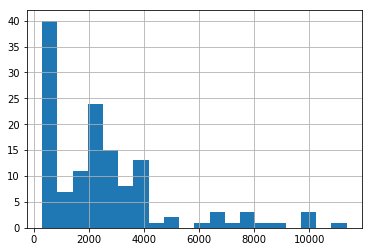

In [115]:
df_txt['sizeB'].hist(bins=20)

print("count=       " +   str(df_txt['sizeB'].count()))
print("sum=     " + sigScale2(df_txt['sizeB'].sum(),'kb','s'))
print("avg=     " + sigScale2(df_txt['sizeB'].mean(),'kb','s'))
print("std=     " + sigScale2(df_txt['sizeB'].std(),'kb','s'))
print("95%case= " + sigScale2(df_txt['sizeB'].mean() + 2*df_txt['sizeB'].std(), 'kb','s'))
print("min=     " + sigScale2(df_txt['sizeB'].min(),'kb','s'))
print("max=     " + sigScale2(df_txt['sizeB'].max(),'kb','s'))
print("plan for 10k source files + accompanying media")

count=       432
sum=     mB: 47.0
avg=     kB: 110.0
std=     kB: 100.0
95%case= kB: 310.0
min=     kB: 0.71
max=     kB: 590.0
plan for 300k image file


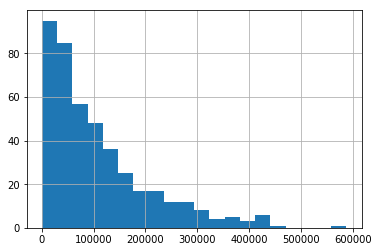

In [116]:
df_img['sizeB'].hist(bins=20)
print("count=       " +   str(df_img['sizeB'].count()))
print("sum=     " + sigScale2(df_img['sizeB'].sum(),'mb','s'))
print("avg=     " + sigScale2(df_img['sizeB'].mean(),'kb','s'))
print("std=     " + sigScale2(df_img['sizeB'].std(),'kb','s'))
print("95%case= " + sigScale2(df_img['sizeB'].mean() + 2*df_img['sizeB'].std(), 'kb','s'))
print("min=     " + sigScale2(df_img['sizeB'].min(),'kb','s'))
print("max=     " + sigScale2(df_img['sizeB'].max(),'kb','s'))
print("plan for 300k image file")

In [117]:
print(list(dydbr.tables.all()))

[dynamodb.Table(name='MonthIdx'), dynamodb.Table(name='Posts'), dynamodb.Table(name='YearIdx')]


### Prep For Storage Transport

In [118]:
Posts = dydbr.Table('Posts')
MonthIdx = dydbr.Table('MonthIdx')
YearIdx = dydbr.Table('YearIdx')

pretty.pprint(MonthIdx.attribute_definitions)
print("items: ",MonthIdx.item_count)
print("size:  ", MonthIdx.table_size_bytes)

pretty.pprint(YearIdx.attribute_definitions)
print("items: ", YearIdx.item_count)
print("size:  ", YearIdx.table_size_bytes)

pretty.pprint(Posts.attribute_definitions)
print("items: ",Posts.item_count)
print("size:  ", Posts.table_size_bytes)

[{'AttributeName': 'monthIdx', 'AttributeType': 'S'}]
items:  24
size:   5710
[{'AttributeName': 'yearIdx', 'AttributeType': 'S'}]
items:  2
size:   4115
[{'AttributeName': '_id', 'AttributeType': 'S'},
 {'AttributeName': '_loc', 'AttributeType': 'S'}]
items:  123
size:   351602


In [119]:
# renderer = mistune.Renderer(escape=True, hard_wrap=True)
# # use this renderer instance
# markdown = mistune.Markdown(renderer=renderer)
# markdown(text)

jumboEnvelope = {'Posts': []}

for filedata in source_data:
    with open(filedata['fullname']) as f:
        post = frontmatter.load(f)
        _id = genId() # to use twice
        Item = {'_id':_id}
        
        Item['_meta'] = {  "_id":_id,
                            "epochCreate":random.randint( 1483232461,  1544835661),
                            "epochUpdate":random.randint( 1483232461,  1544835661),
                            "isDraft": True,
                            "layout":"single_column"}
        Item['_loc'] = getPath(Item, filedata['shortname']) # depends on epochCreate
        Item['loc'] = {'slug':getSlug(filedata['shortname']), 
                       'root':'/',
                       'full':Item['_loc']}
        Item['_meta']["@ref"] = "s3://"+"BUCKET/"+Item['_loc']
        Item['type'] = 'post'
        
        written = {  '_meta':post.metadata,
                     'Title':post['title'],
                     'Authors':[{'name':'Eric D Moore', '_id':genId()}],
                     'Content':{'raw': post.content,
                                'processed':{'engine':"1:True"
                                            ,'md':"1:True"
                                            ,'html':"1:True"}}}

        # dydb dont like date times - find'em and swtichem to strings
        if 'date' in written['_meta'].keys():
            written['_meta']['date'] = int(written['_meta']['date'].timestamp())

        Item['related'] = {'Next'   :{"1":True}, 
                           "Prev"   :{"1":True},
                           "Related":{"1":True}}

        Item['_plugins'] = {"imageGrid":{"_meta":{"1":True}, 
                                         "input":{"1":True},
                                         "_config":{"1":True},
                                         "rendered":{"1":True}}}            

        # dydb wont allow empty strings
        if "" in written['_meta'].values():
            pretty.pprint(post.metadata)

        # remove uneeded lower case Title - since the index expcets it upcase.            
        Item.pop('title', None)

        Item['written'] = written
        Item['_meta']['sizeB'] = filedata['sizeB']
        Item['_meta']['bytes'] = getsizeof(str(Item))

        # form and add the ReqEnvelope to the batchEnvelope
        Request = {'PutRequest':{'Item':Item}}
        jumboEnvelope['Posts'].append(Request)

    ## at the end of each batchChunk now in a batchEnvelope - add the envelop to the 


# skip4now(upload to s3)
# upload to metadata skip4now(+ s3 location)
# If Errors then you will see output needing to be reviewed.

# Quick Preview

r =random.randint(0,20)
print(len(jumboEnvelope['Posts']))
for i in range(r, r+1):
    pretty.pprint(jumboEnvelope['Posts'][i]['PutRequest']['Item'])

135
{'_id': '953bd28e-9220-409e-954b-a2a4e6e20d62',
 '_loc': '/2017/On-Coffee-Snobbery',
 '_meta': {'@ref': 's3://BUCKET//2017/On-Coffee-Snobbery',
           '_id': '953bd28e-9220-409e-954b-a2a4e6e20d62',
           'bytes': 1411,
           'epochCreate': 1543499339,
           'epochUpdate': 1496540514,
           'isDraft': True,
           'layout': 'single_column',
           'sizeB': 483},
 '_plugins': {'imageGrid': {'_config': {'1': True},
                            '_meta': {'1': True},
                            'input': {'1': True},
                            'rendered': {'1': True}}},
 'loc': {'full': '/2017/On-Coffee-Snobbery',
         'root': '/',
         'slug': 'On-Coffee-Snobbery'},
 'related': {'Next': {'1': True}, 'Prev': {'1': True}, 'Related': {'1': True}},
 'type': 'post',
 'written': {'Authors': [{'_id': '1e1a8c0b-57eb-4d04-9d57-4abc19b03ba9',
                          'name': 'Eric D Moore'}],
             'Content': {'processed': {'engine': '1:True',
     

In [78]:
class YearIndex():
    def __init__(self):
        self.posts = {}
        self._years = {}
        self._months = {}
        self._meta = {"minDate":float("Inf"), "maxDate":0, "bytes":0, "continued":None}
    
    def __len__(self):
        return len(self._years)
    
    def __getitem__(self, key):
        return self._years[key]
    
    def __iter__(self):
        for k in self._years:
            yield k
    def __next__(self):
        for k in self._years:
            yield k
    
    def _setMeta(self, cdt, ref_top_obj):   
        if not ref_top_obj['_meta']:
            pretty.pprint(ref_top_obj)
        
        self._metaDates(cdt, ref_top_obj['_meta'])
        self._metaSize(ref_top_obj)
        
    def _metaSize(self, ref_top_obj):
        ref_top_obj['_meta']['bytes'] = getsizeof(str(ref_top_obj['posts'])) + getsizeof(str(ref_top_obj['_meta']))
    
    def _metaDates(self, cdate, ref_obj):
        
        if not ref_obj or 'minDate' not in ref_obj:
            pretty.pprint(ref_obj)

        if cdate < ref_obj['minDate']:
            ref_obj['minDate'] = cdate
        if cdate > ref_obj['maxDate']:
            ref_obj['maxDate'] = cdate
        
    
    def merge(self, sibling):
        raise NotImplemented
        
    def update(self, item):
        Item = Dict(item)
        createTime = Item._meta.epochCreate
        
        # convert to "year-month" key like 2018-12
        yearKey = time.strftime('%Y', time.localtime(createTime))
        monthKey = time.strftime('%Y-%m', time.localtime(createTime))
        
        # todo: early return if cache already has value
        
        self.posts[Item._id] = {"title":Item.written.Title, 
                                 "loc":Item._loc, 
                                 "createDate": Item._meta.epochCreate}
        
        # Year Structure
        if yearKey not in self._years:
            self._years[yearKey] = {"yearIdx":str(yearKey),
                                    "months":{},
                                    "posts":{},
                                    "_meta":{"bytes":0,
                                             "minDate":float('Inf'),
                                             "maxDate":0}}
        
        self._years[yearKey]['posts'][Item._id] = {"title":Item.written.Title, "loc":Item._loc,
                                                         "createDate": Item._meta.epochCreate}
        
        # Month Structure        
        if monthKey not in self._years[yearKey]['months']:
            self._years[yearKey]['months'][monthKey] = {"posts":{},"_meta":{"bytes":0,
                                                       "minDate":float('Inf'),
                                                       "maxDate":0}}   

        self._years[yearKey]['months'][monthKey]['posts'][Item._id] = {"title":Item.written.Title, "loc":Item._loc,
                                              "createDate": Item._meta.epochCreate}
        
        self._setMeta(createTime, self._years[yearKey]['months'][monthKey])
        self._setMeta(createTime, self._years[yearKey])
        self._setMeta(createTime, self.__dict__)
        return len(self.posts)
        
    def data(self):
        # chunk up into multiple index pre-filling the continued sections
        return {"_meta":self._meta, "years":self._years}
        
    def chunks(self):
        raise NotImplemented



In [79]:
class MonthIndex():
    def __init__(self):
        self.posts = {}
        self._months = {}
        self._meta = {"minDate":float("Inf"), 
                      "maxDate":0, 
                      "bytes":0, 
                      "continued":None}
    
    def __getitem__(self, key):
        return self._months[key]
    
    def __len__(self):
        return len(self._months)
    
    def __iter__(self):
        for k in self._months:
            yield k
    def __next__(self):
        for k in self._months:
            yield k        
    
    def _setMeta(self, cdt, ref_top_obj):   
        if not ref_top_obj['_meta']:
            pretty.pprint(ref_top_obj)
        
        self._metaDates(cdt, ref_top_obj['_meta'])
        self._metaSize(ref_top_obj)
        
    def _metaSize(self, ref_top_obj):
        ref_top_obj['_meta']['bytes'] = getsizeof(str(ref_top_obj['posts'])) + getsizeof(str(ref_top_obj['_meta']))
    
    def _metaDates(self, cdate, ref_obj):
        
        if not ref_obj or 'minDate' not in ref_obj:
            pretty.pprint(ref_obj)

        if cdate < ref_obj['minDate']:
            ref_obj['minDate'] = cdate
        if cdate > ref_obj['maxDate']:
            ref_obj['maxDate'] = cdate
    
    
    def update(self, item):
        Item = Dict(item)
        createTime = Item._meta.epochCreate
        # failed to use this var
        yearMonthKey = time.strftime('%Y-%m', time.localtime(createTime))
        
        if yearMonthKey in self._months and Item._id in self._months[yearMonthKey]['posts']:
            # Did we add something to the cache?
            return False
        else:
            if yearMonthKey not in self._months:
                self._months[yearMonthKey] = {"monthIdx":str(yearMonthKey),
                                              "posts":{},
                                              "_meta":{"bytes":0,
                                                       "minDate":float('Inf'),
                                                       "maxDate":0}}
        
            self._months[yearMonthKey]['posts'][Item._id] = {"title":Item.written.Title, 
                                                          "loc":Item._loc,
                                                          "createDate": Item._meta.epochCreate}
        
            self._setMeta(createTime, self._months[yearMonthKey])
            self._setMeta(createTime, self.__dict__)
        return True

    def data(self):
        return {"_meta":self._meta, "months":self._months}
    
    def merge(self, sibling):
        raise NotImplemented
    
    def chunks(self):
        raise NotImplemented

## Upload to DynamoDB 

### Assumptions: 

#### Input Data Shape
    top level:
    {'<tableName>':[ {1.Request} ]} 
       
        the list of requssts may be 1000+ long 
            ...too long for the batch writer
        When processing, will need to chunk that up into size:25

        writer can handle 16 MB payload,
        25 put or delete requests
        Individual items to be written can be as large as 400 KB.
        although it is interesting that .400M x25 = 10M (not 16M) ???  ¯\_(ツ)_/¯
    
    
    1.Request <Dict>
    {'<MethodType>':{'Item:{<schema compliant data>}}}


### Process Sketch
    for each data table listed in the source data
        while counter is less than 25
            process each item
            copy the PutRequest/Item for the data table into multi-table envelope
            increent evelope request counter
            Determine year idx key
                add if needed && increment counter
                otherwise udpate the payload of the existing key in the evelope
            Determine the month idx key
                add if needed && increment counter
                otherwise udpate the payload of the existing key in the evelope
            repeat until counter hits 25
        then submit the envelope to the writer
        continue to drain all the items for this table to the writer
        then move to next table...

In [101]:
mailCrate = []
i = 0 

def reshape(jumbo):
    LIMIT = 26
    LOWER = random.randint(0,20)
    UPPER = LOWER + LIMIT
    
    for table in jumbo:
        batchSet = []
        yearIdx = YearIndex()
        monthIdx = MonthIndex()
        global i
        
        while(i < len(jumbo[table])):
            while(len(batchSet) +len(monthIdx) +len(yearIdx) < 24): # because they can jump by two
                req = jumbo[table][i]
                
                op = list(req.keys())[0]
                item = req[op]['Item']

                batchSet.append(item)
                yearIdx.update(item)
                monthIdx.update(item)
                i += 1
            
            # create batchObj
            batchEnvelope = {}
            if len(yearIdx):
                batchEnvelope['YearIdx'] = []
                for key in yearIdx:
                    batchEnvelope['YearIdx'].append({"PutRequest":{"Item": yearIdx[key]}})
                
            if len(monthIdx):
                batchEnvelope['MonthIdx'] = []
                for key in monthIdx:
                    batchEnvelope['MonthIdx'].append({"PutRequest":{"Item": monthIdx[key] }})
                
            if len(batchSet): 
                batchEnvelope['Posts'] = []
                for item in batchSet:
                    batchEnvelope['Posts'].append({"PutRequest":{"Item": item }})
            
            mailCrate.append(batchEnvelope)
            
            # dump it all into Dynamo 
            try:
                r = dydbr.batch_write_item(RequestItems=batchEnvelope)
                if r and 'UnprocessedItems' in r and r['UnprocessedItems']: #exists and is notEmpty
                    time.sleep(1.000)
                    r = dydbr.batch_write_item(RequestItems=r.UnprocessedItems)
                    print(">> found unprocessed")
                    pretty.pprint(r)
            except Exception as e:
                print(e)
                print(">>>>>^^^^^^")
                # pretty.pprint(r)
            
            # and reset
            batchSet = []
            yearIdx = YearIndex()
            monthIdx = MonthIndex()
                                  

In [103]:
reshape(jumboEnvelope)

IndexError: list index out of range

In [104]:
i

134

### Existing Upload Process

In [ ]:
for batch in mailingCrate:
    # pretty.pprint(batch)
    try:
        r = dydbr.batch_write_item(RequestItems=batch)
        if 'UnprocessedItems' in r and r['UnprocessedItems']: #and map has contents
            time.sleep(.500)
            dydbr.batch_write_item(RequestItems=r.UnprocessedItems)
            print(">> found unprocessed")
            pretty.pprint(r)
    except Exception as e:
        print(e)
        print(">>>>>^^^^^^")
        for post in batch['Posts']:
            pretty.pprint(post['PutRequest']['Item'])

**Target**

        {
	    "@_id":"<uuid>",
	    "*loc":"",
	    "_meta*":{        
	        "_id":"<S uuid >",
	        "createDate":"<S> or <DateObj>",
	        "udpateDate":"<S> or <DateObj>",
	        "isDraft": true,
	        "@ref":"<s3://>",
	        "layout":"single column"
	    },
	    "_loc*":{
	        "slug":"<partial_url>",
	        "root":"/blog",
	    },
	    "written*":{
	        "_meta":{
	            "post_metadata1":"Value1",
	            "post_metadata2":"Value2",
	            "post_metadata3":"Value3",
	            "tags":["<S>"]
	        },
	        "Title":"",
	        "Authors":[],
	        "Content":{
	            "raw":"",
	            "processed":{
	                "engine":"",
	                "md":{
	                    "total":"",
	                    "excerpt":"",
	                    "more":"",
	                    "plugins":{
	                        "nameID":[],
	                        "nameID":[]
	                    }
	                },
	                "html":{
	                    "total":"",
	                    "excerpt":"",
	                    "more":"",
	                    "plugins":{
	                        "nameID1":[],
	                        "nameID2":[]
	                    }
	                }
	            }
	        },
	    "@type":"post"
	    },
	    "_related*":{
			    "Next":{},
	        "Prev":{},
	        "Related":[
			        {"_id":""},
			        {"_id":""},
			        {"_id":""}
				   ]
	    },
	    "_plugins*":{
	        "plugin1":{
	            "rendered":"",
	            "input":"",
	            "_config":{
	                "":""
	            },
	            "_meta":{
	                "asd":"asd"
	            }
	        },
	        "pluginTwo":{
	            "rendered":"",
	            "input":"",
	            "_config":{
	                "":""
	            },
	            "_meta":{
	                "asd":"asd"
	            }
	        },
	    },
	}		


### Proto Query

In [ ]:
p = dydbr.Table('Posts')
p.get_item( Key={'Pub-YYYY-MM':'Pub-2018-12',
            'Slug':"A-Talent-of-Attracting-Talent"},
            ReturnConsumedCapacity='INDEXES'
          )

### For Consideration

1. Populate a `Tags` table
2. Populate a `Categories` table

### Querying

In [ ]:
Posts = dydbr.Table('Posts')

In [ ]:
query_params = {
    'Select':'ALL_ATTRIBUTES', # 'ALL_ATTRIBUTES'|'ALL_PROJECTED_ATTRIBUTES'|'SPECIFIC_ATTRIBUTES'|'COUNT'
    'Limit':100,
    'ConsistentRead':True,
    'ScanIndexForward':True,
    'KeyConditionExpression': Key('Slug').eq('The-Importance-of-Ownership'),
    'ReturnConsumedCapacity':'TOTAL' #  'INDEXES'|'TOTAL'|'NONE',
#     IndexName='string',
#     FilterExpression=Attr('myattribute').eq('myvalue'),
#     ExpressionAttributeNames={
#         'string': 'string'
#     },
#     ExpressionAttributeValues={
#         'string': 'string'|123|Binary(b'bytes')|True|None|set(['string'])|set([123])|set([Binary(b'bytes')])|[]|{}
#     }
#     ExclusiveStartKey={
#         'string': 'string'|123|Binary(b'bytes')|True|None|set(['string'])|set([123])|set([Binary(b'bytes')])|[]|{}
#     },
#     ProjectionExpression='string',
}
response = Posts.query(**query_params)
response

In [ ]:
Posts.query( KeyConditionExpression = Key('Slug').eq('The-Importance-of-Ownership'))

In [ ]:
# pretty.pprint(dir(Key('Slug').begins_with("The")))
Posts.query( KeyConditionExpression = Key('Slug').begins_with("The"))

In [ ]:
paginator = dydbr.meta.client.get_paginator('query')


### Required Dynamo Data Shape

In [ ]:
"""Target:

    {'Posts': [
                { 'PutRequest': {
                        'Item': {
                            'string1': "string"
                            'string2': 123
                            'string2': Binary(b'bytes')
                            'string2': True
                            'string2': None
                            'string2': set(['string'])
                            'string2': set([123])
                            'string2': set(Binary[b'bytes'])
                            'string2': []
                            'string2': {}
                        }
                    },
                },
                { 'PutRequest': {
                        'Item': {
                            'string1': 'string'
                            'string2': 123
                        }
                    },
                },
                { 'PutRequest': {
                        'Item': {
                            'string1': 'string'
                            'string2': set(['string'])
                        }
                    },
                }
            ]
    }"""

In [ ]:
"""{ 'Posts': [ 
        { 'PutRequest': { 
                'Item': { 
                    'Slug': 'The-Importance-of-Ownership',
                    'Title': 'The Importance of Ownership',
                     '_content': 'The American Dream\n',
                     '_id': 'd6c9370e-5d10-4321-af8a-d41e2757394c',
                     'categories': ['business'],
                     'comments': False,
                     'cover_detail': '/images/crooked-house_square@450x450.jpg',
                     'cover_index': '/images/crooked-house_square@450x450.jpg',
                     'description': 'description - lorem '
                                    'ipsum',
                     'subtitle': 'subtitle - lorem ipsum',
                     'tags': [ 'values','ownership','culture','destiny','content.creation','rules','terms'],
                     'toc': True
                     }
                 }
        }"""

### S3 Stuff Later